In [66]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [77]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [68]:
os.system("aws --region us-west-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

os.system("aws --region us-west-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

0

In [69]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['54.177.136.107',
  '54.176.104.220',
  '54.219.133.117',
  '3.101.38.31',
  '13.57.202.135',
  '54.183.86.163',
  '52.53.189.131',
  '54.183.233.197',
  '3.101.26.141',
  '54.193.44.178',
  '13.56.233.56',
  '52.53.216.62',
  '50.18.30.77',
  '54.183.161.69',
  '50.18.65.117',
  '18.144.100.9',
  '54.177.3.164',
  '52.53.169.95',
  '54.193.51.153',
  '54.219.178.251',
  '54.153.15.149',
  '54.219.241.45',
  '54.183.222.251',
  '54.177.48.238',
  '54.67.87.19',
  '54.176.154.172'],
 26)

In [70]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-54-177-136-107.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-176-104-220.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-219-133-117.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-101-38-31.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-57-202-135.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-183-86-163.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-53-189-131.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-183-233-197.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-101-26-141.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-54-193-44-178.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-56-233-56.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-52-53-216-62.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-50-18-3

In [71]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)


total_count = 24


nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

2


(['54.67.87.19', '54.176.154.172'], [])

In [72]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 1234 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [73]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [74]:
## First Time Setup

lines, len(lines)

(['54.177.136.107',
  '54.176.104.220',
  '54.219.133.117',
  '3.101.38.31',
  '13.57.202.135',
  '54.183.86.163',
  '52.53.189.131',
  '54.183.233.197',
  '3.101.26.141',
  '54.193.44.178',
  '13.56.233.56',
  '52.53.216.62',
  '50.18.30.77',
  '54.183.161.69',
  '50.18.65.117',
  '18.144.100.9',
  '54.177.3.164',
  '52.53.169.95',
  '54.193.51.153',
  '54.219.178.251',
  '54.153.15.149',
  '54.219.241.45',
  '54.183.222.251',
  '54.177.48.238',
  '54.67.87.19',
  '54.176.154.172'],
 26)

In [30]:
results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-52-53-216-62.us-west-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: Warning: Permanently added 'ec2-18-144-100-9.us-west-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: Warning: Permanently added 'ec2-50-18-65-117.us-west-1.compute.amazonaws.com' (ED25519) to th

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [31]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated bec

Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.a

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Building dependency tree...Reading package lists...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found



Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN           

job.sh: 11: sdk: not found


Reading package lists...ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

Building dependency tree...
Reading state information...
Reading package lists...
Reading state information...

Building dependency tree...
Reading state information...

Reading state information...

Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

Reading state information...
Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.

Reading state information...
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to rem

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.

Reading state information...

Reading state information...

Reading state information...

Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Cloning into 'bftsmartt'...
Cloning into 'bftsmartt'...



Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
curl is already the newest version (7.81.0-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


Cloning into 'bftsmartt'...
Cloning into 'bftsmartt'...
Cloning into 'bftsmartt'...
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:  

job.sh: 11: sdk: not found



Reading state information...
ant is already the newest version (1.10.12-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec

Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [395 kB]
Get:4 http://us-west-

Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [5828 B]
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.9 kB]
Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [395 kB]
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [185 kB]
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.2 kB]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.0 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [18

Hit:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [395 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [395 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [395 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [41.0 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [125 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [14.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [30.2 kB]
Get:36 http://security.ubuntu.com/ubuntu

Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [610 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [171 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.5 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [271 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [41.3 kB]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [604 B]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [899 kB]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [185 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c

Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.5 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [271 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [41.3 kB]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [604 B]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [185 kB]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [899 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [18.8 kB]
Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [35.3 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [8452 B]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-upda

Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [610 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [171 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.5 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [271 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.co

Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [610 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [171 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [14.5 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [271 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [41.3 kB]
Get:16 http://u


Reading state information...
Fetched 24.8 MB in 4s (5708 kB/s)
Reading package lists...Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Fetched 24.8 MB in 4s (5825 kB/s)
Reading package lists...Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [252 B]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-de

Building dependency tree...Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]

The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu 

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Fetched 24.8 MB in 4s (5786 kB/s)
Reading package lists...Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/u

Get:20 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.1.0-2ubuntu1~22.04 [976 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.3.0-1ubuntu1~22.04 [20.8 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://us-wes

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.1.0-2ubuntu1~22.04 [10.4 kB]
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.3.0-1ubuntu1~22.04 [2284 kB]
Fetched 24.8 MB in 4s (5759 kB/s)
Reading package lists...Get:35 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:19 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 63.7 MB in 2s (31.8 MB/s)
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
0 upgraded, 52 newly installed, 0 to remove and 45 not upgraded.
Need to get 63.7 MB of archives.
After this operation, 207 MB 

Get:33 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:35 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:36 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:21 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.1.0-2ubuntu1~22.04 [154 kB]
(Reading database ... 63657 files and directories currently installed.)
Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:37 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package libtirpc-dev:amd64.
Get:26 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main a

Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:29 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.1 [237 kB]
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:30 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.1 [922 kB]
Get:33 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:34 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:14 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.1.0-2ubuntu1~22.04 [126 kB]
Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:15 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.1.0-2ubuntu1~22.04 [30.2 kB]
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.1.0-2ubuntu1~22.04 [47.4 kB]
Get:16 http://us-west-1.ec2.archive.ub

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Fetched 63.7 MB in 2s (26.5 MB/s)
Get:29 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.1 [237 kB]
Get:30 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:31 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:32 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.1 [922 kB]
Fetched 63.7 MB in 2s (27.1 MB/s)
Get:33 http://us-wes

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package rpcsvc-proto.
Get:37 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:38 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:39 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:40 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:42 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Get:43 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:44 htt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 63.7 MB in 3s (22.5 MB/s)
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libc-dev-bin.
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libcrypt-dev:amd64.Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...

Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Selecting previously unselected package g++-11.
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.1.0-2ubuntu1~2

Unpacking make (4.3-4.1build1) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package cpp-11.
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package gcc-11-base:amd64.
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
(Reading database ... 63657 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.1_all.deb ...
Selecting previously unselected package cpp-11.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.1) ...
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04) ...
Fetched 63.7 MB in 4s (16.3 MB/s)
Get:24 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.3.0-1ubuntu1~22.04 [2087 kB]
Selecting previously unselected package cpp-11.
Selecting previously unselected package cpp.
Preparing to unpack .../10-cpp-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking cpp-11 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package cpp.
Pr

Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
(Reading database ... 63657 files and directories currently installed.)
Get:27 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:28 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:29 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.1 [237 kB]
Preparing to unpack .../13-libgomp1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../0

Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../17-liblsan0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libubsan1:amd64.
Prepa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:42 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:43 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Preparing to unpack .../18-libtsan0_11.3.0-1ubuntu1~22.04_amd64.deb ...
Get:44 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:45 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Unpacking libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libubsan1:amd64.
Get:46 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Get:47 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Reading state information...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package gcc-11.
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Preparing to unpack .../22-gcc-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package build-essential.
Selecting previously unselected package libmpc3:amd64.
Unpacking gcc-11 (11.3.0-1ubuntu1~22.04) ...Unpacking libisl23:amd64 (0.24-2build1) ...

Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../32-build-essential_12.9ubuntu3

Setting up manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up lto-disabled-list (24) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Setting up libfile-fcntllock-perl (0.22-3bui

Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package g++-11.
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Reading package lists...Selecting previously unselected package gcc.
Selecting previously unselected package gcc-11-base:amd64.
Setting up liblsan0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04) ...

Unpacking gcc (4:11.2.0-1ubuntu1) ...
Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Bu

Selecting previously unselected package gcc.
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Selecting previously unselected package bzip2.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking lto-disabled-list (24) ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Unpacking bzip2 (1.0.8-5build1) ...
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libcc1-0:amd64.
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-me

Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.1) ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package fonts-dejavu-core.
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Selecting previously unselected package build-essential.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package fakeroot.
Unpacking build-essential (12.9ubuntu3) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb

Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...

Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package libquadmath0:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Selecting previously unselected package bzip2.
Preparing to unpack .../20-libquadmath0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpac

Setting up libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libjbig0:amd64.
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package g++-11.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking g++-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package make.
Selecting previously unselected package libdeflate0:amd64.
Selecting previously unselected package libdpkg-perl.
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.1_all.deb ...
Unpacking make (4.3-4.1build1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.1) ...
Selecting previously unselected package libgd3:amd64.
Reading package lists...Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libalgorithm-diff-perl.

Setting up libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libstdc++-11-dev:amd64.


Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package fakeroot.
Setting up manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package fakeroot.
Selecting previou

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libalgorithm-merge-perl.
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.1.0-2ubuntu1~22.04 [1069 kB]
Selecting previously unselected package bzip2.
Setting up libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Unpa

Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.1_all.deb ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.1) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-72.79_amd64.deb ...
Selecting previously unselected package libtiff5:amd64.
Unpacking linux-libc-dev:amd64 (5.15.0-72.79) ...
Selecting previously unselected package g++.Setting up libjpeg8:amd64 (8c-2ubuntu10) ...

Setting up dpkg-dev (1.21.1ubuntu2.1) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up dpkg-dev (1.21.1ubuntu2.1) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
S

Selecting previously unselected package build-essential.
Setting up g++-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Preparing to unpack .../14-libitm1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package fontconfig-config.
Unpacking libitm1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unse

Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libdeflate0:amd64.
Setting up lto-disabled-list (24) ...
Selecting previously unselected package libdeflate0:amd64.
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../19-libubsan1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking libubsan1:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...Unpacking libdeflate0:amd64 (1.10-2) ...

Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up g++-11 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Selecting previously unselected package libxpm4:amd64.
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Get:22 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.3.0-1ubuntu1~22.04 [2517 kB]
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../16-libasan6_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libasan6:amd64 (11.3.0-1ubuntu1~22.04) ...
Get:23 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.3.0-1ubuntu1~22.04 [20.1 MB]
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...Selecting previously unselected package libc-devtools.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up lto-disabled-list (24) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubu

job.sh: 11: sdk: not found


Setting up libquadmath0:amd64 (12.1.0-2ubuntu1~22.04) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package g++-11.
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../25-g++-11_11.3.0-1ubuntu1~22.04_amd64.deb ...
Reading package lists...Unpacking g++-11 (11.3.0-1ubuntu1~22.04) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode


Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.
Setting up libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Building dependency tree...Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up gcc-11-base:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...

No VM guests are running outdated hypervisor (qemu) binaries

Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.5 [41.7 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.1 [12.0 kB]
Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common3 amd64 0.8-5ubuntu5 [23.7 kB]
Selecting previously unselected package libdpkg-perl.
Get:9 htt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.1_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.1) ...
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up libgcc-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libatomic1:amd64.
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../15-libatomic1_12.1.0-2ubuntu1~22.04_amd64.deb ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Unpacking libatomic1:amd64 (12.1.0-2ubuntu1~22.04) ...
Setting up gcc-11 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up cpp-11 (11.3.0-1ubuntu1~22.04) ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up fontconfig

job.sh: 11: sdk: not found


Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libc-devtools.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unsel

Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Reading package lists...Setting up libdeflate0:amd64 (1.10-2) ...

Building dependency tree...Selecting previously unselected package libjbig0:amd64.
Setting up linux-libc-dev:amd64 (5.15.0-72.79) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...

Reading state information...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libgomp1:amd64 (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libcc1-0:amd64.
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../12-libcc1-0_12.1.0-2ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package g++.
Unpacking libcc1-0:amd64 (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libwebp7:amd64.
Setting up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
     

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found




Reading state information...
Building dependency tree...
Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.
Reading package lists...
No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...

Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package ca-certificates-java.
Building dependency tree...Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Reading package lists...
Reading state information...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
           

job.sh: 11: sdk: not found


Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.5 [41.7 kB]
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.1 [12.0 kB]
Setting up libdeflate0:amd64 (1.10-2) ...Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]

Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common3 amd64 0.8-5ubuntu5 [23.7 kB]
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-client3 amd64 0.8-5ubuntu5 [28.1 kB]
Get:12 htt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
Get:11 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Get:13 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java

job.sh: 11: sdk: not found


Selecting previously unselected package manpages-dev.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Selecting previously unselected package gcc.
Unpacking manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5) ...

Reading state information...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5_amd64.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5) ...
Setting up dp

job.sh: 11: sdk: not found


Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Selecting previously unselected package libpcsclite1:amd64.
0 upgraded, 18 newly installed, 0 to remove and 45 not upgraded.
Need to get 46.3 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Get:2 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Get:3 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Get:4 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.5 [41.7 kB]
Get:5 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certifica

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
(Reading database ... 69393 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libasound2-data.
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Setting up libdpkg-perl (1.21.1ubuntu2.1) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Unpacking bzip2 (1.0.8-5build1) ...
curl is already the newest version (7.81.0-1ubuntu1.10).
curl set to manually installed.
0 upgraded, 0 new

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize fro

Selecting previously unselected package alsa-topology-conf.
Fetched 46.3 MB in 1s (37.1 MB/s)

Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Selecting previously unselected package alsa-topology-conf.
(Reading database ... 69393 files and directories currently installed.)
Fetched 46.3 MB in 1s (32.5 MB/s)
Selecting previously unselected package alsa-topology-conf.

Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Reading package lists...curl is already the newest version (7.81.0-1ubuntu1.10).
curl set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Setting up libtsan0:amd64 (11.3.0-1ubuntu1~22.04) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up cpp-11 (11.3.0-1ubuntu

Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package alsa-ucm-conf.
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5_amd64.deb ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...
Selecting previously unselected package fonts-dejavu-core.

Reading state information...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...

Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Selecting previously unselected package alsa-ucm-conf.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Unpacking java-common (0.72build2) ...
Setting up libstdc++-11-dev:amd64 (11.3.0-1ubuntu1~22.04) ...
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Selecting previously unselected package java-common.
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Unpacking java-common (0.72build2) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Setting up g++-11 (11.3.0-1ubuntu1~22.04) ...
Preparing to unpack ...

Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.1_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.1) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5_amd64.deb ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...
Selecting previously unselected package libcups2:amd64.
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Selecting previously unselected package libcups2:amd64.
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.1_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.1)

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...

Reading state information...Selecting previously unselected package libxpm4:amd64.

Fetched 46.3 MB in 1s (40.2 MB/s)
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...

Running kernel seems to be up-to-date.
(Reading database ... 95%
No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package libgd3:amd64.
(Reading database .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package alsa-topology-conf.
Selecting previously unselected package libharfbuzz0b:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
(Reading database ... 69393 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Selecting previously unselected package libpcsclite1:amd64.
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Preparing to unpac

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking ant (1.10.12-1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Selecting previously unselected package libasound2-data.
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package ant-optional.
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking liba

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package alsa-topology-conf.
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Get:18 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
(Reading database ... 69393 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package ca-certificates-java.
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...

Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up li

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pemSelecting previously unselected package alsa-ucm-conf.

Reading package lists...Selecting previously unselected package libavahi-common3:amd64.
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pemPreparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.5_all.deb ...

Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5_amd64.deb ...
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pemUnpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...


Adding debian:GTS_Root_R3.pem
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5) ...
Building dependency tree...Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Mi

Get:6 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Selecting previously unselected package libcups2:amd64.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Get:7 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common-data amd64 0.8-5ubuntu5 [23.9 kB]
Adding debian:COMODO_RSA_Certification_Authority.pem
Get:8 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-common3 amd64 0.8-5ubuntu5 [23.7 kB]
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.1_amd64.deb ...
Get:9 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libavahi-client3 amd64 0.8-5ubuntu5 [28.1 kB]
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Adding debian:Amazon_Root_CA_2.pem
Get:10 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.1 [264 kB]
Get:18 http://us-west-1.ec2.archive.ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:GlobalSign_Root_E46.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:Secure_Global_CA.pem
Adding debian:emSign_Root_CA_-_C1.pem
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:Certigna_Root_CA.pem
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Adding debian:Certum_EC-384_CA.pem
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libasound2:amd64.
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Selecting previously unselected package ant.
Adding debian:QuoVadis_Root_CA_1_G3.pem
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:certSIGN_ROOT_CA.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Adding debian:NAVER_Global_Root_Cer

job.sh: 11: sdk: not found


Selecting previously unselected package ant-optional.
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Adding debian:GlobalSign_Root_CA_-_R3.pemUnpacking ant-optional (1.10.12-1) ...

Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Selecting previously unselected package libavahi-client3:amd64.
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5) ...
Adding debian:QuoVadis_Root_CA_2_G3.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up java-common (0.72build2) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2)

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Setting up ant (1.10.12-1) ...
Adding debian:Certum_Trusted_Network_CA_2.pem
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:EC-ACC.pem
Adding debian:Hellenic_Ac

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Selecting previously unselected package libasound2-data.
Adding debian:GTS_Root_R2.pem
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
done.
done.
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:Secure_Global_CA.pem
Adding debian:emSign_Root_CA_-_C1.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:Certigna_Root_CA.pem
Adding debian:Certum_EC-384_CA.pem
Setting up ant (1.10.12-1) ...
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Selecting previously unselected package libasound2:amd64.


job.sh: 11: sdk: not found


Selecting previously unselected package ant-optional.
Building dependency tree...Setting up ant (1.10.12-1) ...
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:Go_Daddy_Class_2_CA.pem
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking default-jre-headless (2:1.11-72build2) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.1_all.deb ...
Setting up ant (1.10.12-1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Setting up ca-certificates-java (20190909ubuntu1.1) ...Setting up ant (1.10.12-1) ...
Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Setting up c

Adding debian:QuoVadis_Root_CA_2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:UCA_Global_G2_Root.pem
Setting up default-jre-headless (2:1.11-72build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:GTS_Root_R1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto modeAdding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem

Adding debian:UCA_Extended_Validation_Root.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:Amazon_R

Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:Amazon_Root_CA_1.pemAdding debian:ANF_Secure_Server_Root_CA.pem

Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Adding debian:ePKI_Root_Certification_Authority.pem
Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemAdding debian:Amazon_Root_CA_1.pem

Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemAdding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.19+7~us1-0ubuntu1~22.04.1_amd64.deb ...
Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:Izenpe.com.pem

Adding debian:ACCVRAIZ1.pem
Adding debian:Cybertrust_Gl

Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pemAdding debian:certSIGN_Root_CA_G2.pem

Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:CA_Disig_Root_R2.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Addin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:DigiCert_Global_Root_CA.pemAdding debian:DigiCert_Global_Root_CA.pem
Adding debian:AffirmTrust_Premium.pem

Adding debian:Baltimore_CyberTrust_Root.pemAdding debian:Hongkong_Post_Root_CA_3.pem

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Selecting previously unselected package libasound2:amd64.
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_

Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pemAdding debian:SSL.com_Root_Certification_Authority_ECC.pem

Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Unpacking ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:GTS_Root_R2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:Certigna.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:DigiCert_Assure

Adding debian:Cybertrust_Global_Root.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pemAdding debian:GLOBALTRUST_2020.pemSetting up libasound2-data (1.2.6.1-1ubuntu1) ...


Selecting previously unselected package default-jre-headless.
Adding debian:SecureSign_RootCA11.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pemUnpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:SZAFIR_ROOT_CA2.pem

Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Adding debian:DigiCert_Global_Root_G3.pemUnpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3) ...

Adding debian:Secu

Setting up default-jre-headless (2:1.11-72build2) ...
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
curl is already the newest version (7.81.0-1ubuntu1.10).
curl set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Adding debian:DigiCert_Global_Root_G2.pemAdding debian:EC-ACC.pem

Setting up openjdk-11-jre-headless:amd64 (11.0.19+7~us1-0ubuntu1~22.04.1) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Selecting previously unselected package ant-optional.
Adding debian:QuoVadis_Root_CA_3.pem
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Adding debian:GlobalSign_Root_CA.pemAdding debian:ACCVRAIZ1.pem

Unpacking ant-optional (1.10.12-1) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:GlobalSign_Root_CA_-_R6.pemAdding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Actalis_Authentication_Root_CA.pem

Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Add

Adding debian:Comodo_AAA_Services_root.pem
Updating certificates in /etc/ssl/certs...
Setting up ant (1.10.12-1) ...
Adding debian:certSIGN_Root_CA_G2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:CA_Disig_Root_R2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:COMODO_ECC_Certification_Authority.pem

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-  

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package alsa-topology-conf.
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Selecting previously unselected package ant-optional.
Adding debian:Hongkong_Post_Root_CA_3.pem
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
(Reading database ... 69393 files and directories currently installed.)
Unpacking ant-optional (1.10.12-1) ...
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Setting up ant (1.10.12-1) ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...

Reading state information...Adding debian:DigiCert_Global_Root_G2.pem


Reading state information...
Setting up ca-certificates-java (20190909ubuntu1.1) ...
Adding debian:ACCVRAIZ1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for readingAdding debian:Actalis_Authentication_Root_CA.pem
: No such file or directory
Selecting previ

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:DigiCert_Trusted_Root_G4.pem
done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode

No VM guests are running outdated hypervisor (qemu) binaries on this host.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:SZAFIR_ROOT_CA2.pem
Setting up ant-optional (1.10.12-1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

update-alternatives: Adding debian:DigiCert_Global_Root_G3.pemusing /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode

Adding debian:T-TeleSec_GlobalRoot_Class_3.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode

Addin

Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:DigiCert_Global_Root_G2.pem
Selecting previously unselected package libpcsclite1:amd64.
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Amazon_Root_CA_4.pem
Preparing to unpack .../13-libpcsclite1_1.9.5-3_amd64.deb ...
Adding debian:Amazon_Root_CA_1.pem
Unpacking libpcsclite1:amd64 (1.9.5-3) ...
Adding debian:AffirmTrust_Commercial.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:GLOBALTRUST_2020.pe

Adding debian:SwissSign_Gold_CA_-_G2.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Setting up java-common (0.72build2) ...
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Updating certificates in /etc/ssl/certs...
Adding debian:AffirmTrust_Networking.pem
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:Certigna.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_CA.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Setting up libpcsclite1:amd64 (1.9.5-3) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debia

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pemdone.

Adding debian:AffirmTrust_Premium.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pemAdding debian:Baltimore_CyberTrust_Root.pem

Adding debian:GTS_Root_R3.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Get:16 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Adding debian:Certum_Trusted_Root_CA.pem
Get:17 http://us-west-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Updating certificates in /etc/ssl/certs.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Amazon_Root_CA_2.pem
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Selecting previously unselected package libasound2:amd64.
Adding debian:SwissSign_Gold_CA_-_G2.pem
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:IdenTrust_Commercial_Root_CA_1.pem

Adding debian:DigiCert_Global_Root_G2.pem
Selecting previo

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:Go_Daddy_Class_2_CA.pem

Selecting previously unselected package libgraphite2-3:amd64.
Reading package lists...Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.5) ...
Building dependency tree...Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...

Reading package lists...Setting up libavahi-common3:amd64 (0.8-5ubuntu5) ...
Building dependency tree...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5) ...
Building dependency tree...Reading package lists...Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.1) ...

Adding debian:emSign_ECC_Root_CA_-_G3.pem
Building dependency tree...Setting up default-jre-headless (2:1.11-72build2) ...
Adding debian:e-Szigno_Root_CA_2017.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Preparing to unpack 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:QuoVadis_Root_CA_2.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:UCA_Extended_Validation_Root.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Network_Solutions_

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Unpacking ant (1.10.12-1) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Amazon_Root_CA_4.pem0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...


Adding debian:AffirmTrust_Commercial.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:UCA_Extended_Validation_Root.pem

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

Selecting previously unselected package ant-optional.
Adding debian:TWCA_Root_Certification_Authority.pemPrepa

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...


Reading state information...
Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

Reading state information...
Adding debian:Go_Daddy_Class_2_CA.pem


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:GTS_Root_R1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Entrust_Root_Certificat

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Atos_TrustedRoot_2011.pem
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Unpacking ant-optional (1.10.12-1) ...
Adding debian:COMODO_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:Entrust_Root_Certification_Authority.pem
Setting up java-common (0.72bui

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Reading package lists...Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R3.pem
Building dependency tree...Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:GTS_Root_R1.pem
done.
done.
Adding debian:D-TRUST_Root_Class_3_CA_2_E

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:ACCVRAIZ1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:EC-ACC.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:AffirmTrust_Networking.

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

No services need to be restarted.

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [32]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'BftSmart_Final': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [33]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  


.....................................................................................Starting a Gradle Daemon (subsequent builds will be faster)
....Starting a Gradle Daemon (subsequent builds will be faster)
...Starting a Gradle Daemon (subsequent builds will be faster)
.Starting a Gradle Daemon (subsequent builds will be faster)
.....Starting a Gradle Daemon (subsequent builds will be faster)
..Starting a Gradle Daemon (subsequent builds will be faster)
.Starting a Gradle Daemon (subsequent builds will be faster)
............................10%.Starting a Gradle Daemon (subsequent builds will be faster)
.10%...Starting a Gradle Daemon (subsequent builds will be faster)
.10%.....10%...Starting a Gradle Daemon (subsequent builds will be faster)
.10%.10%..10%...10%..10%.10%..10%.10%...10%....................10%..............................................................................................20%......10%.....20%...........20%....20%......20%........20%..................20%..

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD 

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installD

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 41s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [34]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove

rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory

rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: rm: cannot remove 'config/currentView'cannot remove 'config4/currentView': No such file or directory: No such file or directory

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.ou

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory


In [35]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(24, 6)

In [16]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [ ]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'NormalRun'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

 2 sec: 3 operations; 3 current ops/sec; [UPDATE AverageLatency(us)=276815.67] 
 276815.67 3 2
 3 sec: 11 operations; 7.98 current ops/sec; [UPDATE AverageLatency(us)=125504.38] 
 125504.38 7.98 3
 4 sec: 22 operations; 11 current ops/sec; [UPDATE AverageLatency(us)=87749.45] 
 87749.45 11 4
 5 sec: 34 operations; 11.99 current ops/sec; [UPDATE AverageLatency(us)=88445.67] 
 88445.67 11.99 5
 6 sec: 47 operations; 13 current ops/sec; [UPDATE AverageLatency(us)=75937.85] 
 75937.85 13 6
 7 sec: 64 operations; 16.98 current ops/sec; [UPDATE AverageLatency(us)=60371.53] 
 60371.53 16.98 7
 8 sec: 82 operations; 18 current ops/sec; [UPDATE AverageLatency(us)=54349.61] 
 54349.61 18 8
 9 sec: 100 operations; 18 current ops/sec; [UPDATE AverageLatency(us)=53562.22] 
 53562.22 18 9
 10 sec: 122 operations; 21.98 current ops/sec; [UPDATE AverageLatency(us)=47796.41] 
 47796.41 21.98 10
 11 sec: 144 operations; 22 current ops/sec; [UPDATE AverageLatency(us)=45217.27] 
 45217.27 22 11
 12 sec: 1

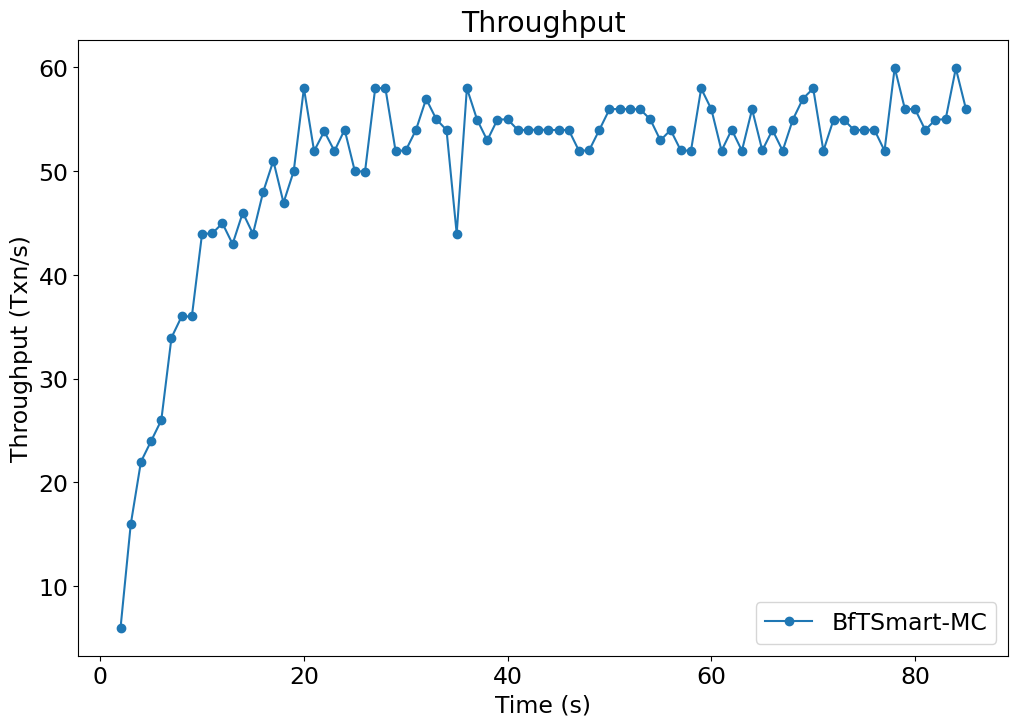

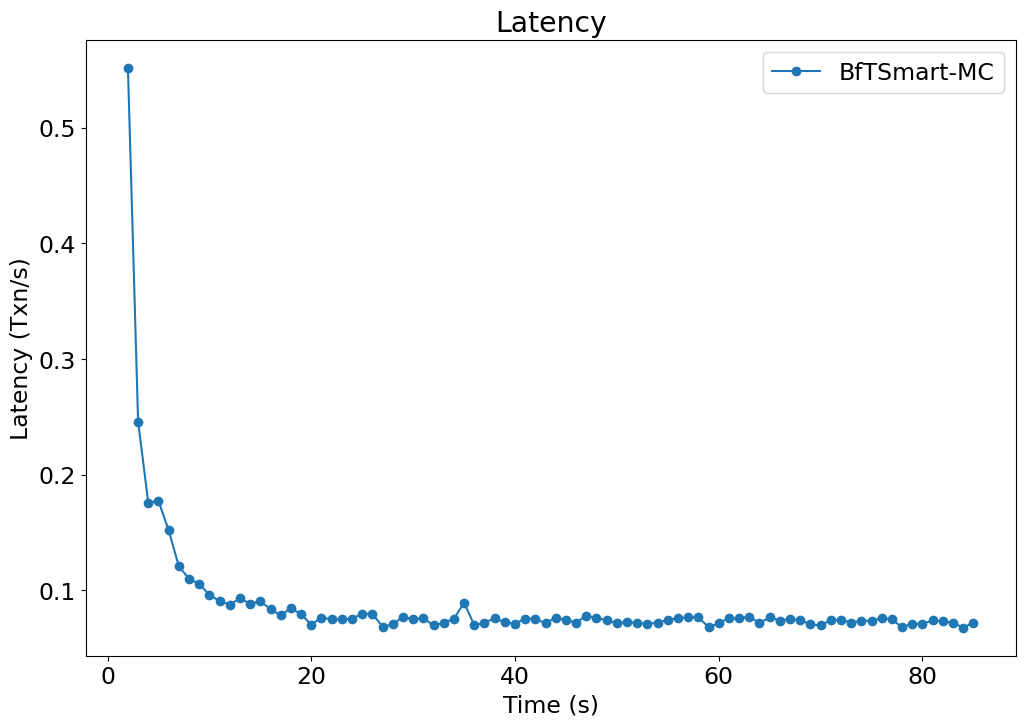

In [82]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

In [83]:
np.average(lats[-50:]), np.average(thputs[-50:]) #  for 2 clusters

(0.0732971288, 54.61659999999999)

In [76]:
np.average(lats[-50:]), np.average(thputs[-50:]) #  for 2 clusters

(0.0732971288, 54.61659999999999)

In [64]:
np.average(lats[-50:]), np.average(thputs[-50:]) # (0.10617928520000001, 85.2884) for 3 clusters

(0.10617928520000001, 85.2884)

In [52]:
np.average(lats[-50:]), np.average(thputs[-50:]) # (0.162774796, 99.2552) for 4 clusters

(0.162774796, 99.2552)

In [65]:
0.162/4, 0.26/6

(0.0405, 0.043333333333333335)

In [41]:
np.average(lats[-50:]), np.average(thputs[-50:])  # (0.2607647412, 139.2918) for 6 clusters

(0.2607647412, 139.2918)

In [ ]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'RemoveViewChangeBftSmartMC'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(125)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1


pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Remote View Change for BftSmart-MC with timeout = 20 s')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

> Task :compileJava

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot rem

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
Usage: java ... YCSBServer <replica_id> with arg0 = 7
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.14.146
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@32910148
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3571b748
-- getConnection HERE 
-- Getting 

nohup: no process found
java: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
rm: cannot remove 'NonLeaderFailure.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-54-183-233-197.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NonLeaderFailure/nohup_client_8.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-3-101-26-141.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/NonLeaderFailure/nohup_client_9.out


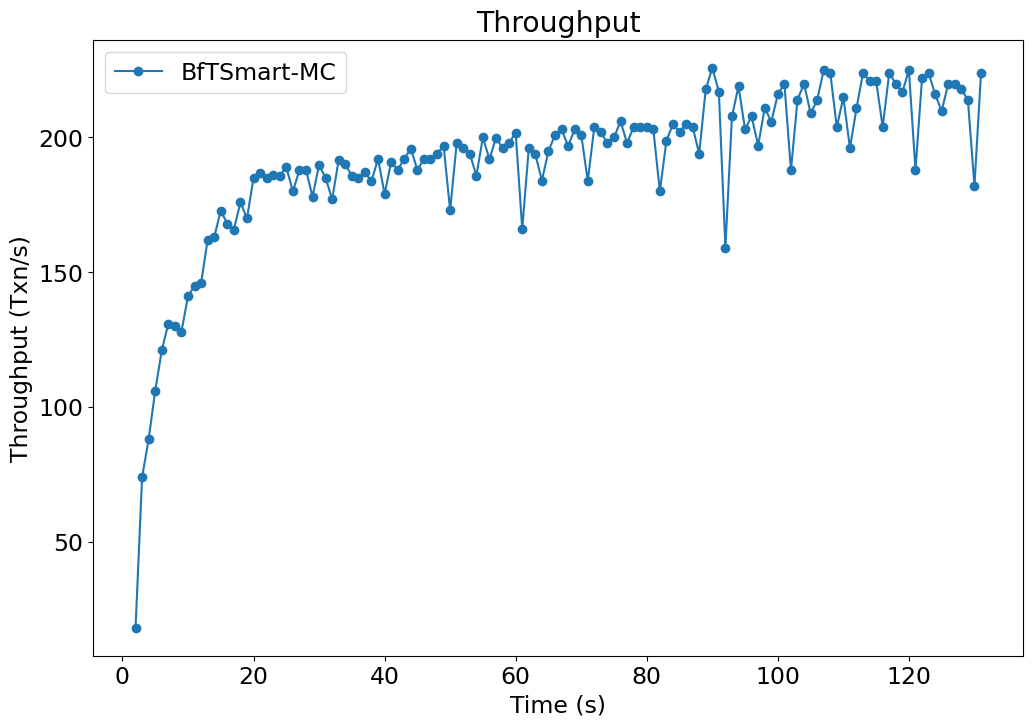

In [71]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'NonLeaderFailure'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [3])
time.sleep(45)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

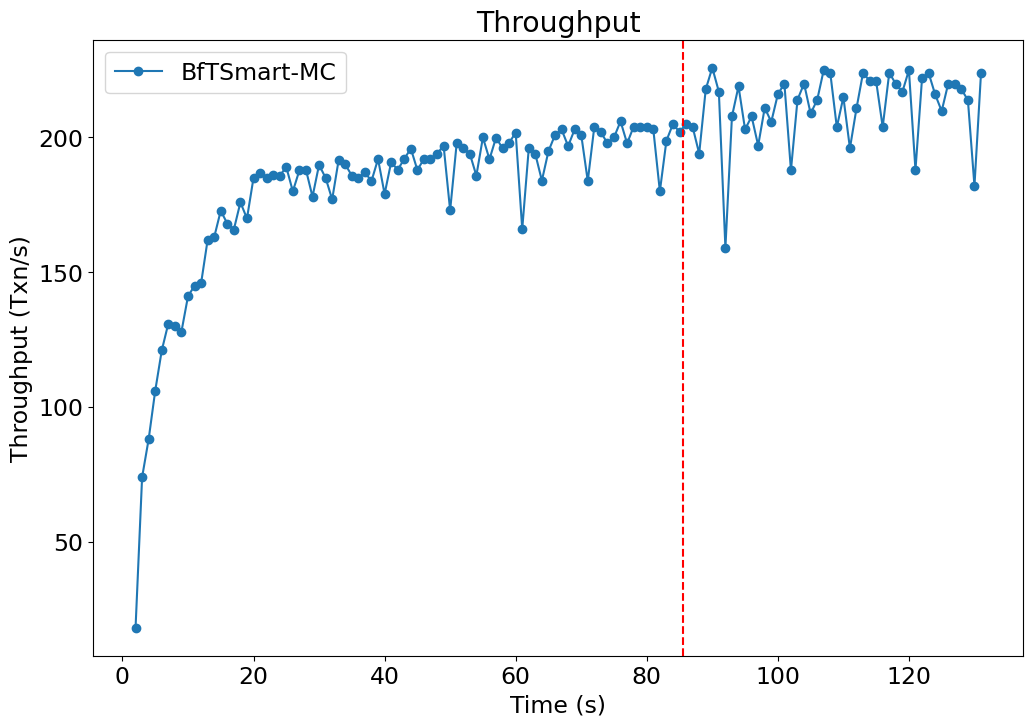

In [78]:
experiment = 'NonLeaderFailure'

PIK = '../Experiments/'+experiment+"/pickle.dat"

data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')
pl.axvline(x=85.48, ls='--', color = 'red')

pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

> Task :compileJava

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

> Task :processResources NO-SOURCE
> Task :classes

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
cannot r

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
Usage: java ... YCSBServer <replica_id> with arg0 = 7
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) are: 11071, /172.31.14.146
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@32910148
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@3571b748
-- getConnection HERE 
-- Getting 

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
rm: cannot remove 'LeaderFailure.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-54-183-233-197.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/LeaderFailure/nohup_client_8.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-3-101-26-141.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/LeaderFailure/nohup_client_9.out


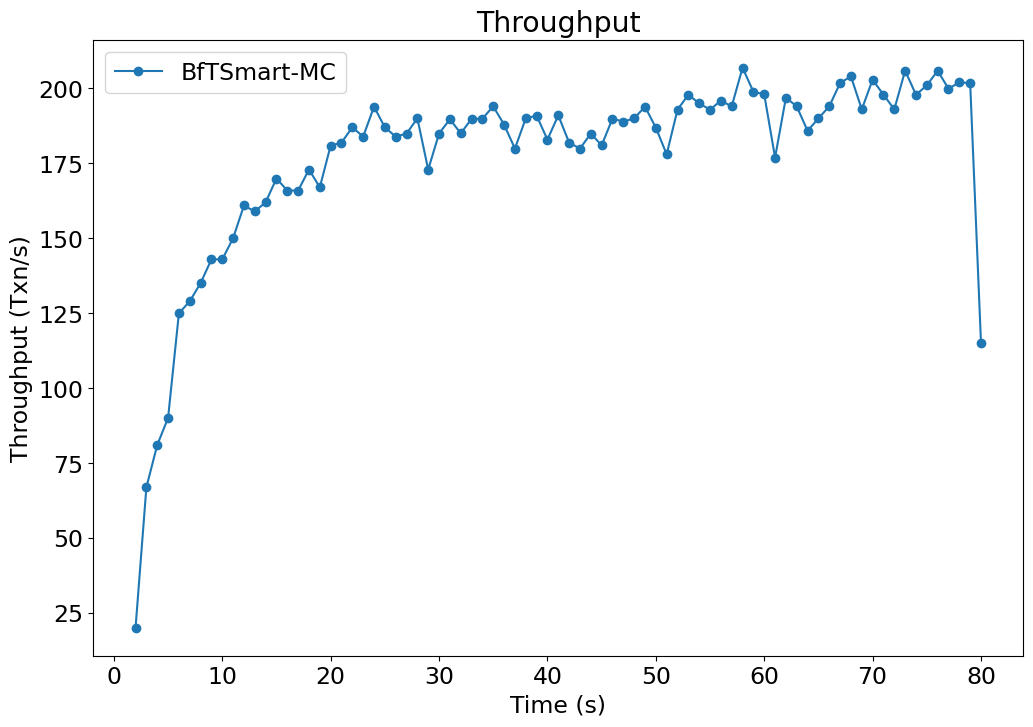

In [77]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'LeaderFailure'


results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(85)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
time.sleep(100)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out.png', dpi = 150)
pl.show()

In [ ]:

# def join_node1(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.233 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node2(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.19.58 11090 11091 config0 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)
        
        
# def join_node3(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 10 172.31.29.208 11100 11101 config0 >../nohup_j1.out 2>&1 &"'
        
        
#         os.system(command)   
        
        
# def join_node4(i):
#     ip = lines[i]
#     if ip!='None':
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 11 172.31.25.228 11110 11111 1 config1 >../nohup_j2.out 2>&1 &"'
        
        
#         os.system(command)           

# # join_node1(11), join_node2(11)

# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)
# # print(results)  

# # time.sleep(45)
# # join_node1(11)
# # time.sleep(45)

# # join_node1(11)
# # time.sleep(45)



# print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# time.sleep(85)



# # join_node1(11)
# # time.sleep(85)


# # join_node2(11)
# # time.sleep(85)




# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(25)



# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(20)


# # def join_node1_check(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup  ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.24.46 11080 11081 config0 >../nohup_j1.out 2>&1 &"'
        
        
# #         print(command)   
        

# # join_node1_check(11)


# # results = Parallel(n_jobs=len(lines))(delayed(kill_clients)(i) for i in range(len(lines)))
# # time.sleep(5)


# # join_node2(11)
# # time.sleep(45)


# # print('XXXXXXXX Started Clients XXXXXXXXXXXX')

# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # time.sleep(45)




# # join_node2(11)
# # time.sleep(45)




# # join_node3(13)
# # time.sleep(40)
# # join_node4(13)
# # time.sleep(40)

# # time.sleep(50)
# check_node(10)

# # time.sleep(100)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# ## Byzantine Remote View Change

# times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_c4_11.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with Byzantine Remote View Change ($nz$=8)')

# # pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('../Experiments/RemoteViewChange.png', dpi = 150)
# pl.show()
# pl.clf()


# ## Join End for Checking

# times_all_clients = []
# ops_all_clients = []
# thputs_all_clients = []
# latencies_all_clients = []


# for ip in clientIps:
#     print(lines.index(ip), nreplicas)
    
    
#     with open('../Experiments/'+experiment+'/'+'nohup_c'+str(nreplicas)+'_'+str(lines.index(ip))+'.out') as f:
#         data = f.readlines()
        
    
    

#     times = []
#     ops = []
#     thputs = []
#     latencies = []



#     for line in data:
#         if 'current ops/sec' in line:
#     #         print(line)

#             numbers_string = line.replace('sec:', ':').replace('operations;', ':').replace(\
#                     'current ops/sec; [UPDATE AverageLatency(us)=', ':').replace('] \n', '').replace(' ','')

        
#             if len(numbers_string.split(':')) == 4:

#                 times.append(float(numbers_string.split(':')[0]))
#                 ops.append(float(numbers_string.split(':')[1]))    
#                 thputs.append(float(numbers_string.split(':')[2]))    
#                 latencies.append(float(numbers_string.split(':')[3])/1e6)    



#     times = np.array(times)
#     ops = np.array(ops)
#     thputs = np.array(thputs)
#     latencies = np.array(latencies)
    
#     times_all_clients.append(times)
#     ops_all_clients.append(ops)    
#     thputs_all_clients.append(thputs)    
#     latencies_all_clients.append(latencies)    

# times_all_clients


# times_all_clients_final = []
# ops_all_clients_final = []
# thputs_all_clients_final = []
# latencies_all_clients_final = []

# for iter_, item in enumerate(times_all_clients):
    

#     np.array(list(set(item).intersection(*times_all_clients[:])))
#     # index = in1d(times_all_clients[0],a1)
#     # result = a2[index]

#     both = set(item).intersection(np.array(list(set(item).intersection(*times_all_clients[:]))))

#     indices_A = [list(item).index(x) for x in list(both)]
#     indices_B = [list(set(item).intersection(*times_all_clients[:])).index(x) for x in both]

#     times_all_clients_final.append(item[indices_A])
#     ops_all_clients_final.append(ops_all_clients[iter_][indices_A])
#     thputs_all_clients_final.append(thputs_all_clients[iter_][indices_A])    
#     latencies_all_clients_final.append(latencies_all_clients[iter_][indices_A])    

# times_all = times_all_clients_final[0]
# ops_all = sum(ops_all_clients_final)
# thputs_all = sum(thputs_all_clients_final)
# latencies_all = sum(latencies_all_clients_final)/len(latencies_all_clients_final)


# print('Average Throughput is ',(ops_all[-1] - ops_all[59])/(times_all[-1] - times_all[59]))

# print('Average Latency is', np.average(latencies_all[60:-10]))

# times_all, thputs_all

# # 40 client threads 2 delivery:93+95/81
# # 100 client threads 2 delivery:124+129/81
# # 100 client threads 8 delivery:138+138/81
# # 40 client threads 8 delivery:95+95/81
# # 40 client threads 16 delivery:97+96/81
# # 40 client threads 16 delivery without IO:93+93/81
# # 100 client threads 16 delivery without IO:146+149/81




# (146+149)/81

# check_node(0)

# for i in [0,1, 4, 14, 15]:
# # for i in [1]:
    
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup_c4_'+str(i)+'.out'


#         os.system(command)

# ## Join Experiment

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))



# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))



# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 



# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  



# # time.sleep(30)
# # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# # print(results)  


# # time.sleep(80)
# # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# # for i in [0,1,4,8,12,13,14]:
# # # for i in [1]:
    
# #     ip = lines[i]
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../nohup'+str(i)+'.out'


# #         os.system(command)

# check_node(11)

# portStart = 11000 + len(nodeIps)*10

# join_lines = []
# currentPort = portStart

# for i in range(len(no_cluster_yet_nodes)):
#     line = str(len(nodeIps)+i) + ' ' + no_cluster_yet_nodes[i] + ' ' + str(currentPort) + ' '+ str(currentPort+1)
#     currentPort = currentPort + 10
#     join_lines.append(line)
#     print('server',line)

# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 8 172.31.31.236 11080 11081 config0
# ./runscripts/smartrun.sh bftsmart.reconfiguration.util.DefaultVMServices 9 172.31.23.57 11090 11091 config1

# ## KILL ALL JAVA



# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ## JOIN COMMAND





# def run_join_client(i):
    
    
    
#     ip = lines[-2]
#     if ip!='None':
#         current = (ip.split('.'))
        
#         join_commands = join_command(i)
        
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmarto; '+join_commands+'"'
        
#         print(command)
#         os.system(command)

# ## JOIN EXPERIMENT

# check_node(3)

# # t1 = time.time()
# # time.sleep(3)
# # t2 = time.time()

# import time
# JoinTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(40)

# for i in range(4,8):
#     print(i)
#     JoinTimes.append(time.time() - t_start)
#     run_join_client(i)
#     time.sleep(40)
    

# check_node(7)


# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# print(results)  

# ip

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out data/MultipleJoins/nohup.out'


#     os.system(command)




# import numpy as np
# import pylab as pl

# times ,thputs, lats = getTimesThputs('data/MultipleJoins/nohup.out')

# JoinTimes

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10], '-o', label='Existing nodes')


# pl.title(r'Throughput with multiple join requests for Bft-Smart ($nz$=4)')

# pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()



# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# # pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:-10], thputs[:-10]*lats[:-10], '-o', label='Existing nodes')


# pl.title(r'Latency*thput with multiple join requests for Bft-Smart ($nz$=4)')

# # pl.axvline(JoinTimes[0], label = '1st join', ls = '--', color = 'r')
# # pl.axvline(JoinTimes[1], label = '2nd join', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel(r'Latency ($\mu$s)')
# pl.legend()
# # pl.savefig('StatsPaper/fig10.png', dpi = 150)
# pl.show()
# pl.clf()

# ## Random Failure

# os.system('git add .; git commit -m "Fixed Failures and Joins";git push')

# experiment = 'bjoin'


# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))


# # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# # print(results) 




# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

# # print(results)  

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# # print(results)  


# print('XXXXXXXX Started Servers XXXXXXXXXXXX')

# time.sleep(40)

# check_node(7)



# def fail_node(i):
#     ip = lines[i]
#     if ip!='None' and ip in nodeIps:
#         current = (ip.split('.'))
                
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo killall java"'
        
#         print(command)
#         os.system(command)

# import numpy as np
# import random

# import time
# # time.sleep(10)

# FailTimes = []


# t_start = time.time()

# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(9)

# time.sleep(45)

# for i in random.sample(list(np.arange(1)), 1):
#     print(i)
#     FailTimes.append(time.time() - t_start)
#     fail_node(0)
#     time.sleep(85)
    

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# ip = lines[-1]
# if ip!='None':
#     current = (ip.split('.'))
#     command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#           +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/nohup.out'

#     print(command)
#     os.system(command)

# FailTimes

# times ,thputs, lats = getTimesThputs('../Experiments/nohup.out')

# import pylab as pl

# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# pl.plot(times[:], thputs[:], '-o', label='BfTSmart-MC')


# pl.title(r'Throughput with single leader failure ($nz$=8)')

# pl.axvline(FailTimes[0], label = '1st fail', ls = '--', color = 'r')
# # pl.axvline(FailTimes[1], label = '2nd fail', ls = '--', color = 'g')
# # pl.axvline(JoinTimes[2], label = '3rd join', ls = '--', color = 'b')
# # pl.axvline(JoinTimes[3], label = '4th join', ls = '--', color = 'orange')

# pl.xlabel('Time (s)')
# pl.ylabel('Throughput (Txn/s)')
# pl.legend()
# # pl.savefig('../Experiments/fig6_leader.png', dpi = 150)
# pl.show()
# pl.clf()


# if not os.path.exists('../Experiments/'+experiment):
#     os.mkdir('../Experiments/'+experiment)

# for ip in nodeIps:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
# #         print(command)
#         os.system(command)

        
# for ip in no_cluster_yet_nodes:
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

#         os.system(command)
        

# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
        
# for ip in clientIps:    
#     i = lines.index(ip)
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j1.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j1.out'
#         print(command)
#         os.system(command)
        
        
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/FinalKeys.pem  ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:/home/ubuntu/nohup_j2.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_j2.out'
#         print(command)
#         os.system(command)        

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))